# Uncertainty Quantification

In the main notebook we 


### Import packages

In [1]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
from scipy import interpolate
import random

# Colab in order to download files
from google.colab import files

# =========================================
# =========================================
# scikit-learn for Machine Learn

# Preprocessing
from sklearn.preprocessing import StandardScaler #Standar scaler for standardization
from sklearn.manifold import TSNE # Dimensionality reduction technique
from sklearn.model_selection import GridSearchCV #Cross-Validation
from sklearn.utils import resample #Resampling
from sklearn.model_selection import train_test_split #Train test split
# Classifiers
from sklearn.svm import SVC #Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier as RF #Random Forests
# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# =======================================
# =======================================
# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

## Part I: Different random seeds




**Import dataset**

In [2]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# The LSBG image dataset
LSBG_data_1 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/LSBG_sample_1.npy"))/255.
LSBG_data_2 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/LSBG_sample_2.npy"))/255.
LSBG_data_3 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/LSBG_sample_3.npy"))/255.
LSBG_data_4 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/LSBG_sample_4.npy"))/255.
# ===============================================================================================
# ===============================================================================================
# The artefacts image dataset
Negative_data_2_1 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Negative_sample_2_1.npy"))/255.
Negative_data_2_2 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Negative_sample_2_2.npy"))/255.
Negative_data_2_3 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Negative_sample_2_3.npy"))/255.
Negative_data_2_4 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Negative_sample_2_4.npy"))/255.
# ===============================================================================================
# ===============================================================================================
# Import the HSC dataset - positives and negatives
HSC_data = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Greco_sample_good.npy"))/255.
HSC_negatives = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Greco_sample_junk.npy"))/255.

Combine LSBG and artefacts data into one dataset

In [4]:
X_mat = np.concatenate((LSBG_data_1,LSBG_data_2,LSBG_data_3,LSBG_data_4,
                        Negative_data_2_1,Negative_data_2_2,Negative_data_2_3,Negative_data_2_4)) # Features matrix
# ==============================================================================
# ==============================================================================
y_label = np.concatenate((np.ones(20000),np.zeros(20000))) # Labels 

In [5]:
seeds = [1,3,18,33,42,96] #Random seeds
n_loops = 6 #Number of loops/random seeds


# ============================================
# Create empty arrays for the evaluation metrics of each loop

Accuracies = np.zeros(n_loops)
Precisions = np.zeros(n_loops)
Recalls = np.zeros(n_loops)
tprs = np.zeros((n_loops,200))
fprs = np.linspace(0,1,200)
AUCs = np.zeros(n_loops)

Calculate over loops

In [6]:
for i in range(n_loops):
  # Clear the backend session
  tf.keras.backend.clear_session()
  # ============================================================================
  # ============================================================================
  # Get local seed
  loc_seed = seeds[i]
  # Now split the DES dataset in training, validation and test sets
  # First in training and a set for validation and test 
  X_tr, X_valt, y_tr, y_valt = train_test_split(X_mat, y_label, test_size=0.25, random_state=loc_seed)
  # Now split in validation and test sets 
  X_val, X_test, y_val, y_test = train_test_split(X_valt, y_valt, test_size=0.50, random_state=loc_seed)
  # ============================================================================ 
  # ============================================================================
  # Now build the model
  model = keras.models.Sequential()
  model.add(InputLayer((64,64,3)))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Flatten())
  model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adadelta(0.1),
                loss= 'binary_crossentropy',
                metrics=['accuracy'])
  # ============================================================================
  # Now fit the model
  model.fit(x=X_tr, y=y_tr,
          epochs=20, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Now predict on the test set
  y_pred = model.predict_classes(X_test)
  # Predict probability scores
  scores = model.predict(X_test)
  # ============================================================================
  # ============================================================================
  # Evaluation metrics 

  Accuracies[i] = accuracy_score(y_test, y_pred)
  Precisions[i] = precision_score(y_test, y_pred)
  Recalls[i] = recall_score(y_test, y_pred)
  AUCs[i] = roc_auc_score(y_test, scores[:,0])
  # ============================================================================
  # Get now false positives and true positives
  fpr, tpr, thresholds = roc_curve(y_test, scores[:,0], pos_label=1.0)
  fpr_unique, ind_unique = np.unique(fpr,return_index=True)
  tpr_unique = tpr[ind_unique]

  # Interpolate the false positives - true positives
  interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
  tprs[i,:] = interp(fprs)

Epoch 1/20
469/469 [==============================] - 3s 7ms/step - loss: 60.2365 - accuracy: 0.7954 - val_loss: 7.4062 - val_accuracy: 0.7176
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 2.8275 - accuracy: 0.8742 - val_loss: 1.3337 - val_accuracy: 0.7820
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.8155 - accuracy: 0.8909 - val_loss: 0.6224 - val_accuracy: 0.8892
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.5157 - accuracy: 0.8990 - val_loss: 0.4578 - val_accuracy: 0.8926
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.4149 - accuracy: 0.9025 - val_loss: 0.3780 - val_accuracy: 0.9088
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3691 - accuracy: 0.9058 - val_loss: 0.3465 - val_accuracy: 0.9056
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3440 - accuracy: 0.9050 - val_loss: 0.3294 - val_accuracy: 0.9096
Epoch

**Print evaluation metrics**

In [7]:
print('Accuracies are:',Accuracies)
print('Precisions are:',Precisions)
print('Recalls are:',Recalls)
print('AUCs are:', AUCs)

Accuracies are: [0.9126 0.9142 0.9152 0.9054 0.9078 0.9128]
Precisions are: [0.89450056 0.88497919 0.884803   0.86141109 0.8683274  0.87997054]
Recalls are: [0.93912019 0.94926948 0.95272727 0.96453043 0.96404583 0.956     ]
AUCs are: [0.96417803 0.9711485  0.96640632 0.96077573 0.96808013 0.96700128]


### Import data in the original split

In [69]:
# For image-based classification
X_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_train.npy")) #Training
X_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_val.npy")) #Validation
X_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_test.npy")) #Test

# Labels
y_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_train.npy")) # Training
y_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_val.npy")) #Validation
y_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_test.npy")) #Test

In [70]:
# Clear the backend session

tf.keras.backend.clear_session()
# build the  original model
model = keras.models.Sequential()
model.add(InputLayer((64,64,3)))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Flatten())
model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer=optimizers.Adadelta(0.1),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [71]:
model.fit(x=X_tr, y=y_tr,
          epochs=20, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))

Epoch 1/20
469/469 [==============================] - 3s 7ms/step - loss: 56.5741 - accuracy: 0.8087 - val_loss: 6.6076 - val_accuracy: 0.7588
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 2.5633 - accuracy: 0.8745 - val_loss: 1.1756 - val_accuracy: 0.8220
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.7502 - accuracy: 0.8918 - val_loss: 0.5923 - val_accuracy: 0.8898
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.4892 - accuracy: 0.8988 - val_loss: 0.4395 - val_accuracy: 0.9054
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.4022 - accuracy: 0.9022 - val_loss: 0.3725 - val_accuracy: 0.9052
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3618 - accuracy: 0.9046 - val_loss: 0.3583 - val_accuracy: 0.8970
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3369 - accuracy: 0.9065 - val_loss: 0.3288 - val_accuracy: 0.9094
Epoch

Predict now and calculate ROC

In [72]:
# Predict classes
y_pred = model.predict_classes(X_test)
# Predict probability scores
scores = model.predict(X_test)

In [79]:
# fpr, tpr for roc curve plot
fpr, tpr, thresholds = roc_curve(y_test, scores[:,0], pos_label=1.0)

fpr_unique, ind_unique = np.unique(fpr,return_index=True)
tpr_unique = tpr[ind_unique]

# Interpolate the false positives - true positives
interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
tpr = interp(fprs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


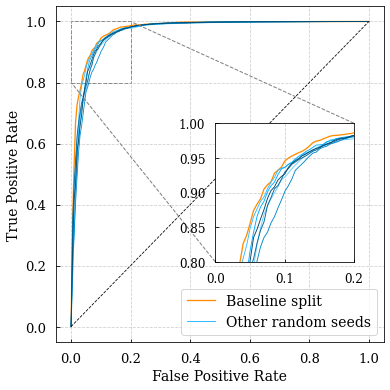

In [89]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

custom_blues = ["#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466"]

x = np.linspace(0,1,100)


fig, ax1 = plt.subplots(figsize = (5.5,5.5))
# =============================================================
# =============================================================
# Main figure

ax1.plot(fprs,tpr,c='darkorange',linewidth=1.3, label='Baseline split')
ax1.plot(fprs,tprs[0],c=custom_blues[0],linewidth=0.8)
ax1.plot(fprs,tprs[1],c=custom_blues[1],linewidth=0.8)
ax1.plot(fprs,tprs[2],c=custom_blues[2],linewidth=0.8,label='Other random seeds')
ax1.plot(fprs,tprs[3],c=custom_blues[3],linewidth=0.8)
ax1.plot(fprs,tprs[4],c=custom_blues[4],linewidth=0.8)
ax1.plot(fprs,tprs[5],c=custom_blues[5],linewidth=0.8)



#Plot diagonal
ax1.plot(x,x, c='k',ls='--',linewidth=0.8)
ax1.grid(ls='--', alpha=0.6)

ax1.set_xlabel('False Positive Rate',fontsize=14);ax1.set_ylabel('True Positive Rate',fontsize=14)
ax1.tick_params(axis='both', labelsize=13)


ax1.legend(frameon=True, loc='lower right', fontsize=14)
# =============================================================
# =============================================================
# Inset figure
left, bottom, width, height = [0.55, 0.33, 0.35, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot(fprs,tpr,c='darkorange',linewidth=1.3)
ax2.plot(fprs,tprs[0],c=custom_blues[0],linewidth=0.9)
ax2.plot(fprs,tprs[1],c=custom_blues[1],linewidth=0.9)
ax2.plot(fprs,tprs[2],c=custom_blues[2],linewidth=0.9)
ax2.plot(fprs,tprs[3],c=custom_blues[3],linewidth=0.9)
ax2.plot(fprs,tprs[4],c=custom_blues[4],linewidth=0.9)
ax2.plot(fprs,tprs[5],c=custom_blues[5],linewidth=0.9)


ax2.set_xlim(0.0,0.2)
ax2.set_ylim(0.8,1.0)
ax2.tick_params(axis='both', labelsize=12)
ax2.grid(ls='--', alpha=0.6)
# =============================================================
# =============================================================
# Format the whole figure
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none",ls='--', ec='0.5')

plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/ROC_other_seeds.pdf")
#files.download("/content/drive/My Drive/Plots/ROC_other_seeds.pdf")
plt.show()